# SageMaker Pipelines - Starting multi-tenant Pipelines (SaaS)

This notebook demonstrates starting SageMaker Pipelines in a software as a service (SaaS) model. 

Here we will start tenant specific pipelines which we created in the previous **[00-DemoCreateTenantPipelines.ipynb](./00-DemoCreateTenantPipelines.ipynb)** notebook with tenant isolation implemented using ABAC role.

This notebook has been tested on SageMaker Studio using the `Data Science` kernel on an `ml.t3.medium`. 


Please make sure your execution role attached to your Studio user profile has `iam:CreatePolicy, iam:CreateRole, iam:AttachRolePolicy and SageMakerFullAccess` permissions/policy attached.

---

### Create ABAC role for starting tenant pipelines
In this section we create an IAM role which only allows to start tenant specific pipelines.

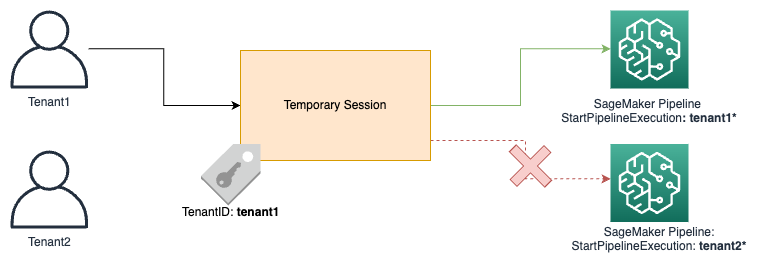

In [2]:
import boto3
import json
import sagemaker.session

sts = boto3.client('sts')
iam = boto3.client('iam')
region = boto3.session.Session().region_name
account_id = sts.get_caller_identity()['Account']

sagemaker_exec_role=sagemaker.session.get_execution_role().split('/')[-1]

start_pipeline_policy_name="DemoStartPipelineExecutionPolicy"

start_pipeline_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": "sagemaker:StartPipelineExecution",
            "Resource": f"arn:aws:sagemaker:{region}:{account_id}:pipeline/${{aws:PrincipalTag/TenantID}}-*"
        }
    ]
}
try:
    start_pipeline_policy = iam.create_policy(
        PolicyName=start_pipeline_policy_name,
        PolicyDocument=json.dumps(start_pipeline_policy_document)
)

except iam.exceptions.EntityAlreadyExistsException:
    # If the policy already exists, get its ARN
    policy = iam.get_policy(PolicyArn=f"arn:aws:iam::{account_id}:policy/{start_pipeline_policy_name}")

    # Print the ARN of the existing IAM policy
    print(f"The IAM policy {start_pipeline_policy_name} already exists with ARN {policy['Policy']['Arn']}")

start_pipeline_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                "AWS": f"arn:aws:sts::{account_id}:assumed-role/{sagemaker_exec_role}/SageMaker"
            },
            "Action": ["sts:AssumeRole","sts:TagSession"],
            "Condition": {
                "StringLike": {
                    "aws:RequestTag/TenantID": "*"
                }
            }
        }
    ]
}

start_pipeline_role_name = "DemoStartPipelineRole"
try:
    start_pipeline_role=iam.create_role(
        RoleName=start_pipeline_role_name,
        AssumeRolePolicyDocument=json.dumps(start_pipeline_role_policy_document)
    )

    iam.attach_role_policy(
        RoleName=start_pipeline_role_name,
        PolicyArn=f"arn:aws:iam::{account_id}:policy/{start_pipeline_policy_name}"
    )
except iam.exceptions.EntityAlreadyExistsException:
    start_pipeline_role = iam.get_role(RoleName=start_pipeline_role_name)
    print(f"The IAM role {start_pipeline_role_name} already exists with ARN {start_pipeline_role['Role']['Arn']}")

The IAM policy DemoStartPipelineExecutionPolicy already exists with ARN arn:aws:iam::130992530969:policy/DemoStartPipelineExecutionPolicy
The IAM role DemoStartPipelineRole already exists with ARN arn:aws:iam::130992530969:role/DemoStartPipelineRole


The previous **[00-DemoCreateTenantPipelines.ipynb](./00-DemoCreateTenantPipelines.ipynb)**  notebook has created these pipelines `tenant1-app1, tenant1-app2, tenant2-app1, tenant2-app2`.  In order to start a tenant specific pipeline we need to provide pipeline name, for that please update `tenant_id` and `app_id` variables in the below code. we construct pipeline name  from these variables in the following way `f"{tenant_id}-{app_id}"` 

For a given tenant, if you provide one of tenants pipeline name you will be able to start the tenants pipeline successsfully. But if you provide a pipeline name of a different tenant you will get AccessDeniedException.

In [3]:
import boto3
import sagemaker
from scripts import utils
from sagemaker.s3 import S3Uploader
sagemaker_session = sagemaker.Session()
bucket_name=sagemaker_session.default_bucket()

In [4]:
def start_pipeline(tenant_id, app_id, bucket_name, temp_session):
    tenant_id=tenant_id
    processing_instance_type="ml.m5.xlarge"
    processing_instance_count=1
    training_instance_type="ml.m5.xlarge" 
    processing_instance_count=1
    training_instance_count=2
    model_version=0
    app_id=app_id

    pipeline_name=f"{tenant_id}-{app_id}"


    #Upload to S3

    s3_uri = f"s3://{bucket_name}/sample-data/{tenant_id}/{app_id}"
    file_path= "sample-data/"
    # Upload the file to the specified S3 bucket
    S3Uploader.upload(file_path, s3_uri)

    # Set up the SageMaker client
    sagemaker_client = temp_session.client('sagemaker')

    response = sagemaker_client.start_pipeline_execution(
                 PipelineName = pipeline_name,
                 PipelineParameters=[
                 {
                     'Name': 'TrainDataPath',
                     'Value': 's3://{}/sample-data/{}/{}/train.csv'.format(bucket_name, tenant_id, app_id)
                 },
                 {
                     'Name': 'TestDataPath',
                     'Value': 's3://{}/sample-data/{}/{}/test.csv'.format(bucket_name, tenant_id, app_id)

                 },
                 {
                     'Name': 'ValidationDataPath',
                     'Value': 's3://{}/sample-data/{}/{}/val.csv'.format(bucket_name, tenant_id, app_id)

                 },
                 {
                     'Name': 'ModelPath',
                     'Value': 's3://{}/xgboost/model_artifacts/'.format(bucket_name)
                 },
                 {
                     'Name': 'TenantID',
                     'Value': "{}".format(tenant_id)
                 },         
                 {
                     'Name': 'TenantTier',
                     'Value': "Bronze"
                 },
                 {
                     'Name': 'BucketName',
                     'Value': "{}".format(bucket_name)
                 },
                 {
                     'Name': 'ModelVersion',
                     'Value': "{}".format(model_version)
                 },
                {
                     'Name': 'AppID',
                     'Value': "{}".format(app_id)
                 },
                 {
                     'Name': 'TrainingInstanceType',
                     'Value': "{}".format(training_instance_type)
                 },
                       {
                     'Name': 'TrainingInstanceCount',
                     'Value': "{}".format(training_instance_count)
                 },

                       {
                     'Name': 'ProcessingInstanceType',
                     'Value': "{}".format(processing_instance_type)
                 },
                       {
                     'Name': 'ProcessingInstanceCount',
                     'Value': "{}".format(processing_instance_count)
                 } ,
                       {
                     'Name': 'ModelPackageGroupName',
                     'Value': f"{tenant_id}-{app_id}-PipelineAppPackageGroup"
                 }
             ]   
         )    

### Start tenant's SageMaker Pipeline

#### Create temp session for tenant1

In [5]:
access_role=start_pipeline_role['Role']['Arn']
temp_session = utils.create_temp_session(access_role, "tenant1", 900)

Assumed role ARN: arn:aws:sts::130992530969:assumed-role/DemoStartPipelineRole/tenant1


#### Start tenant1 Pipeline

In [6]:
start_pipeline("tenant1", "app1", bucket_name, temp_session)

#### Confirm tenant1 cant run tenant2's pipeline 

In [7]:
start_pipeline("tenant2", "app1", bucket_name, temp_session)

ClientError: An error occurred (AccessDeniedException) when calling the StartPipelineExecution operation: User: arn:aws:sts::130992530969:assumed-role/DemoStartPipelineRole/tenant1 is not authorized to perform: sagemaker:StartPipelineExecution on resource: arn:aws:sagemaker:us-east-1:130992530969:pipeline/tenant2-app1 because no identity-based policy allows the sagemaker:StartPipelineExecution action

#### Now that we have started pipelines, please wait for pipelines execution to complete and then move onto Inference . See [02-DemoTenantPipelinesInference.ipynb](./02-DemoTenantPipelinesInference.ipynb)